In [315]:
import json
import os
import copy
import numpy as np
import pandas as pd
import time
import sys
sys.path.append("../")

from cfmining.predictors import GeneralClassifier_Shap
from cfmining.utils import get_data_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment functions

In [316]:
def test_prob_max_estimation(X, model_shap, n_open, n_fixed_change):
    estimated_max = {
        "shap" : [],
        "shap_add" : []
    }

    assert X.shape[1] >= (n_open + n_fixed_change)

    for i in range(100):
        solution = X.sample(1).values[0]
        model_shap.set_pivot(solution)

        # Select random open vars
        open_vars = np.random.randint(0, X.shape[1], n_open).tolist()
        
        # Select some random fixed vars
        fixed_vars = [k for k in range(X.shape[1]) if k not in open_vars]
        fixed_vars = np.random.choice(fixed_vars, n_fixed_change, replace = False).tolist()
        
        # Change values of fixed var to random values (not equal to the original value)
        for k in fixed_vars:
            solution[k] = np.random.choice(X.iloc[:, k].unique())

        
        prob_max = model_shap.predict_max(solution, open_vars)
        estimated_max["shap"].append(prob_max)
        prob_max = model_shap.estimate_predict_max(solution, open_vars)
        estimated_max["shap_add"].append(prob_max)

        model_shap.clear_cache()  
    
    return estimated_max

def plot_prob_max_estimation(estimated_max, title = "Comparison of max prob estimation"):
    shap = estimated_max["shap"]
    shap_add = estimated_max["shap_add"]
    idx = np.argsort(shap)
    shap = np.array(shap)[idx]
    shap_add = np.array(shap_add)[idx]

    for i in range(100):
        plt.plot(
            [i, i], [shap[i], shap_add[i]],
            color="black",
            alpha = 0.6,
            marker = "."
        )

    plt.scatter(range(100), shap, label = "Shap", color = "blue")
    plt.scatter(range(100), shap_add, label = "Shap add", color = "red")
    plt.legend()
    plt.ylabel("Max probability estimated")
    plt.title(title)
    #plt.show()

In [317]:
def share_axes(axes, sharex=True, sharey=True):
    if isinstance(axes, np.ndarray):
        axes = axes.flat  # from plt.subplots
    elif isinstance(axes, dict):
        axes = list(axes.values())  # from plt.subplot_mosaic
    else:
        axes = list(axes)
    ax0 = axes[0]
    for ax in axes:
        if sharex:
            ax.sharex(ax0)
            if not ax.get_subplotspec().is_last_row():
                ax.tick_params(labelbottom=False)
        if sharey:
            ax.sharey(ax0)
            if not ax.get_subplotspec().is_first_col():
                ax.tick_params(labelleft=False)

## German with 4 features

In [318]:
X_train, Y_train, model, outlier_detection, individuals = get_data_model("german_small")

In [319]:
model_shap = GeneralClassifier_Shap(model, outlier_detection, X_train, tree = True, threshold = 0)
list(zip(X_train.columns, model_shap.shap_max))

[('LoanAmount', 0.2148563443187087),
 ('LoanDuration', 0.30247125936709424),
 ('OwnsHouse', 0.0588587129877713),
 ('is_male', 0.03217353955452502)]

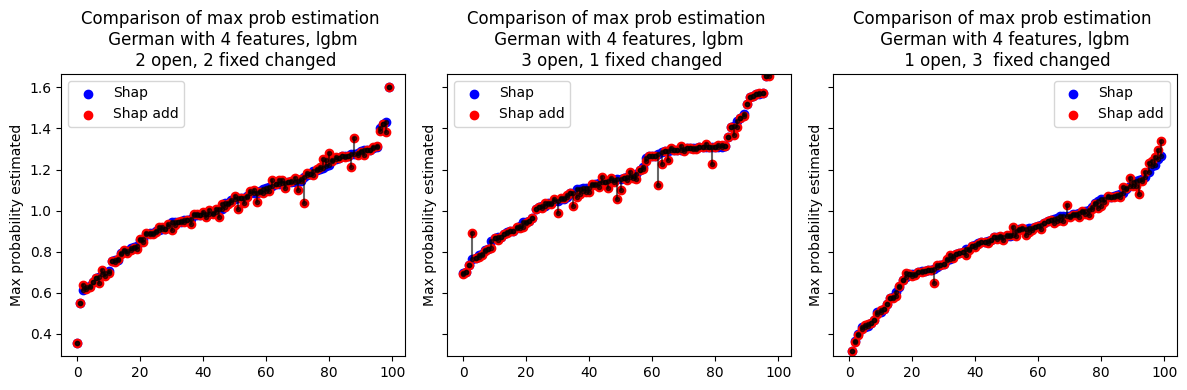

In [320]:
fig = plt.figure(figsize = (12, 4))
axes = []
ax = plt.subplot(1, 3, 1)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 2, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, lgbm \n 2 open, 2 fixed changed")

ax = plt.subplot(1,3, 2)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 3, 1)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, lgbm \n 3 open, 1 fixed changed")

ax = plt.subplot(1, 3, 3)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 1, 3)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, lgbm \n 1 open, 3 fixed changed")

share_axes(axes)
plt.tight_layout()
plt.show()

In [321]:
model = LogisticRegression(max_iter = 1000, C = 100).fit(X_train, Y_train)
model.score(X_train, Y_train)
model_shap = GeneralClassifier_Shap(model, outlier_detection, X_train, tree = False, threshold = 0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

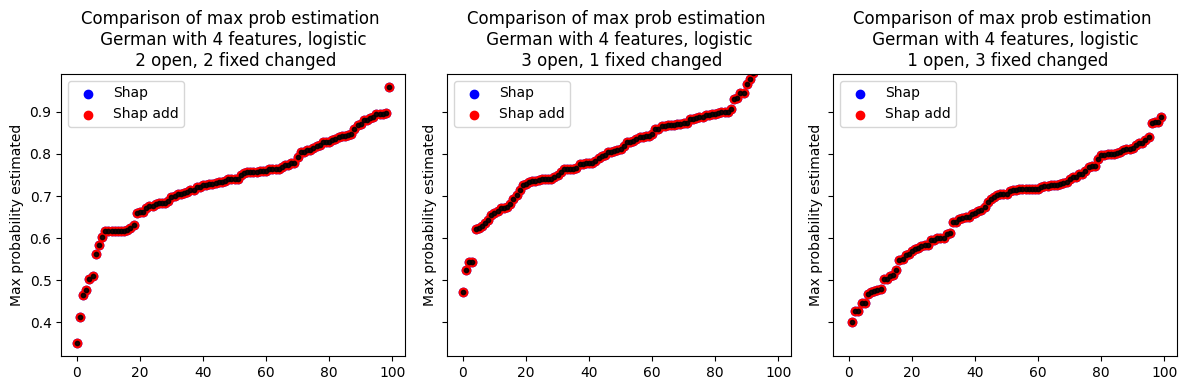

In [322]:
fig = plt.figure(figsize = (12, 4))
axes = []
ax = plt.subplot(1, 3, 1)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 2, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, logistic \n 2 open, 2 fixed changed")

ax = plt.subplot(1,3, 2)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 3, 1)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, logistic \n 3 open, 1 fixed changed")

ax = plt.subplot(1, 3, 3)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 1, 3)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German with 4 features, logistic \n 1 open, 3 fixed changed")

share_axes(axes)
plt.tight_layout()
plt.show()

## German

In [323]:
X_train, Y_train, model, outlier_detection, individuals = get_data_model("german")

In [324]:
model_shap = GeneralClassifier_Shap(model, outlier_detection, X_train, tree = True, threshold = 0)
list(zip(X_train.columns, model_shap.shap_max))

[('ForeignWorker', 0.0),
 ('Single', 0.012508977411916793),
 ('Age', 0.12090514895763321),
 ('LoanDuration', 0.24920124800128834),
 ('LoanAmount', 0.1715473673161673),
 ('LoanRateAsPercentOfIncome', 0.11763378574721237),
 ('YearsAtCurrentHome', 0.058741729420700446),
 ('NumberOfOtherLoansAtBank', 0.035534892848291734),
 ('NumberOfLiableIndividuals', 0.015390220550156555),
 ('HasTelephone', 0.03140585436469866),
 ('CheckingAccountBalance_geq_0', 0.015194756212556604),
 ('CheckingAccountBalance_geq_200', 0.02748726184770045),
 ('SavingsAccountBalance_geq_100', 0.0),
 ('SavingsAccountBalance_geq_500', 0.0),
 ('MissedPayments', 0.05223298102883688),
 ('NoCurrentLoan', 0.0),
 ('CriticalAccountOrLoansElsewhere', 0.13225797851718826),
 ('OtherLoansAtBank', 0.01718415305841306),
 ('HasCoapplicant', 0.0),
 ('HasGuarantor', 0.02804026456391879),
 ('OwnsHouse', 0.06863609160140624),
 ('RentsHouse', 0.01413265257525374),
 ('Unemployed', 0.0),
 ('YearsAtCurrentJob_lt_1', 0.03359732342484547),
 ('Ye

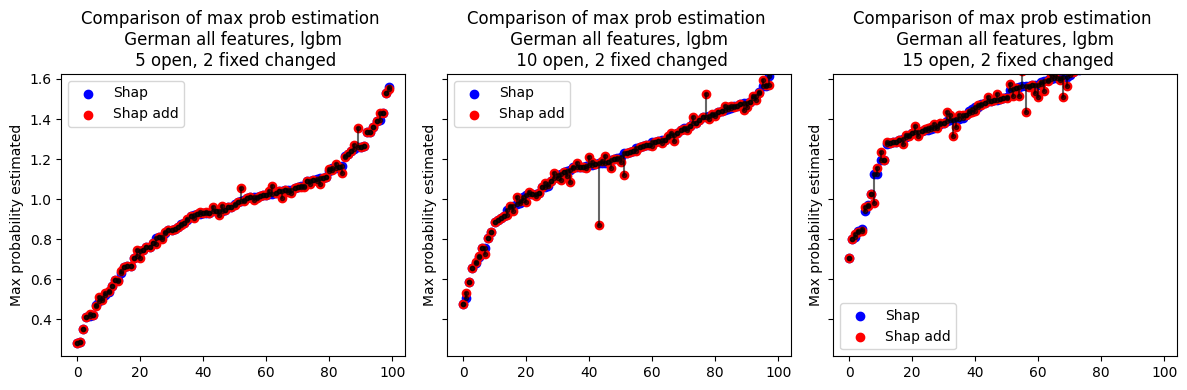

In [325]:
fig = plt.figure(figsize = (12, 4))
axes = []
ax = plt.subplot(1, 3, 1)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 5, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, lgbm \n 5 open, 2 fixed changed")

ax = plt.subplot(1,3, 2)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 10, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, lgbm \n 10 open, 2 fixed changed")

ax = plt.subplot(1, 3, 3)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 15, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, lgbm \n 15 open, 2 fixed changed")

share_axes(axes)
plt.tight_layout()
plt.show()

In [326]:
model = LogisticRegression(max_iter = 1000, C = 100).fit(X_train, Y_train)
model.score(X_train, Y_train)
model_shap = GeneralClassifier_Shap(model, outlier_detection, X_train, tree = False, threshold = 0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

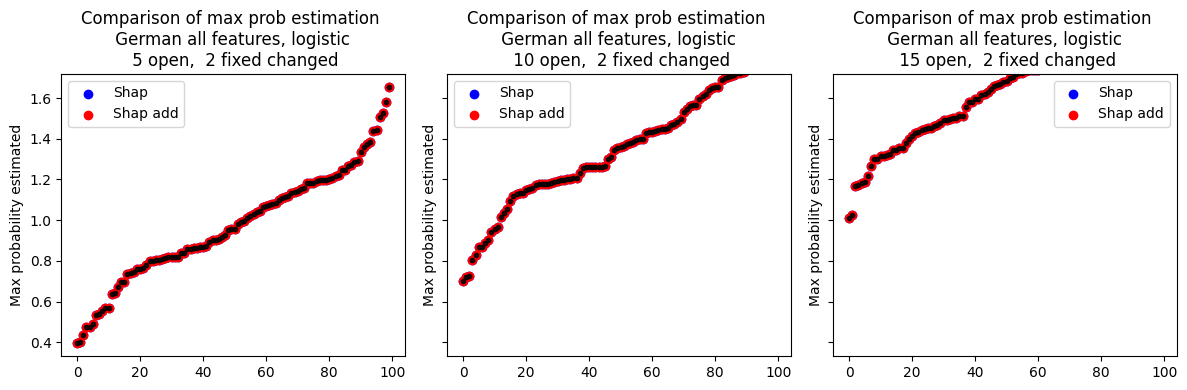

In [327]:
fig = plt.figure(figsize = (12, 4))
axes = []
ax = plt.subplot(1, 3, 1)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 5, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, logistic \n 5 open,  2 fixed changed")

ax = plt.subplot(1,3, 2)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 10, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, logistic \n 10 open,  2 fixed changed")
ax = plt.subplot(1, 3, 3)
axes.append(ax)

estimated_max = test_prob_max_estimation(X_train, model_shap, 15, 2)
plot_prob_max_estimation(estimated_max, "Comparison of max prob estimation \n German all features, logistic \n 15 open,  2 fixed changed")

share_axes(axes)
plt.tight_layout()
plt.show()